In [1]:
# Dependencies
import tweepy
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())


In [16]:
# Target Search Term
target_terms = ("@BBC", "@CBS", "@CNN", "@FoxNews", "@nytimes")

# List to hold average sentiment
results_list = []
ind_results_df = pd.DataFrame(columns=["News Outlet", "Compound Score", "Date", "Tweet Count"])

# Loop through all target users
for target in target_terms:

    # Variables for holding average sentiments
    compound_list = []
    positive_list = []
    negative_list = []
    neutral_list = []

    # List to hold individual sentiments
    tweet_time = []
    news_outlet = []
    tweet_count = []
    tweet_text=[]
    # Run search around each tweet
    public_tweets = api.search(target, count=100)
    counter = 1
    # Loop through all tweets
    for tweet in public_tweets["statuses"]:
                
        #Get the tweet time
        raw_time = tweet["created_at"] 
        converted_time = datetime.strptime(raw_time, "%a %b %d %H:%M:%S %z %Y")
                
        # Run Vader Analysis on each tweet
        results = analyzer.polarity_scores(tweet["text"])

        # Add each value to the appropriate individual tweet list 
        tweet_time.append(converted_time)
        news_outlet.append(target)
        tweet_count.append(counter)
        tweet_text.append(tweet["text"])
        
        # Add each value to the appropriate list to compute averages
        compound_list.append(results["compound"])
        positive_list.append(results["pos"])
        negative_list.append(results["neg"])
        neutral_list.append(results["neu"])
        counter = counter + 1
        
    # Create a dictionary of the average Sentiments
    sentiment = {
        "News Outlet": target,
        "Compound Score": np.mean(compound_list),
        "Postive Score": np.mean(positive_list),
        "Neutral Score": np.mean(neutral_list),
        "Negative Score": np.mean(negative_list)}
  
    # Append the dictionary to results_list
    results_list.append(sentiment)
    
    # Create dictionary of individual tweet information
    ind_tweet = {"News Outlet": news_outlet, 
                 "Tweet Text": tweet_text,
                 "Positive Score": positive_list,
                 "Negative Score": negative_list,
                 "Neutral Score": neutral_list,
                 "Compound Score": compound_list, 
                 "Date": tweet_time, 
                 "Tweet Count": tweet_count}

    # Append the dictionary to individual results list
    temp_df = pd.DataFrame(ind_tweet)
    #print(temp_df)
    ind_results_df = ind_results_df.append(temp_df)

# display dataframe with individual tweet results
ind_results_df.head()

C:\Users\llreb\Anaconda3\envs\PythonData\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


,Compound Score,Date,Negative Score,Neutral Score,News Outlet,Positive Score,Tweet Count,Tweet Text
0,-0.0258,2018-10-03 23:09:51+00:00,0.211,0.655,@BBC,0.135,1,RT @carolecadwalla: Perfect. I look forward to...
1,-0.0258,2018-10-03 23:09:41+00:00,0.211,0.655,@BBC,0.135,2,RT @carolecadwalla: Perfect. I look forward to...
2,-0.0258,2018-10-03 23:09:35+00:00,0.211,0.655,@BBC,0.135,3,RT @carolecadwalla: Perfect. I look forward to...
3,0.0772,2018-10-03 23:09:22+00:00,0.000,0.936,@BBC,0.064,4,RT @carolecadwalla: Number of @bbc reports on ...
4,-0.4588,2018-10-03 23:09:16+00:00,0.217,0.783,@BBC,0.000,5,RT @Amador_OEA: #UNsays Courts in #Nicaragua h...


In [17]:
# Create a DataFrame using results_list and display
results_df = pd.DataFrame(results_list).round(3)
results_df

,Compound Score,Negative Score,Neutral Score,News Outlet,Postive Score
0,-0.043,0.109,0.814,@BBC,0.078
1,0.234,0.022,0.872,@CBS,0.107
2,-0.079,0.116,0.823,@CNN,0.061
3,-0.067,0.100,0.814,@FoxNews,0.086
4,0.016,0.053,0.866,@nytimes,0.081


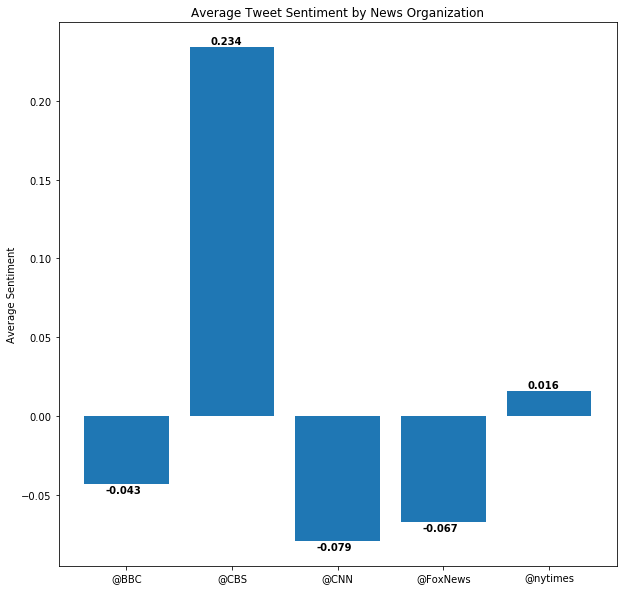

In [23]:
plt.figure(figsize=(10,10))
x_axis = np.arange(len(results_df))
plt.bar(x_axis, results_df["Compound Score"])
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, results_df["News Outlet"])
plt.title("Average Tweet Sentiment by News Organization")
#plt.xlabel("News Organization")
plt.ylabel("Average Sentiment")
#label the bars with sentiment value
for i, v in enumerate(results_df["Compound Score"]):
    if results_df["Compound Score"][i]<0:
        plt.text(i-0.2, v-0.007, str(v), color='black', va='bottom', fontweight='bold')
    else:
        plt.text(i-0.2, v+0.007, str(v), color='black', va='top', fontweight='bold')
        
plt.savefig("AvgSentiment.png")

In [19]:
# Write individual tweet results to CSV

ind_results_df.to_csv("DataOutput.csv")

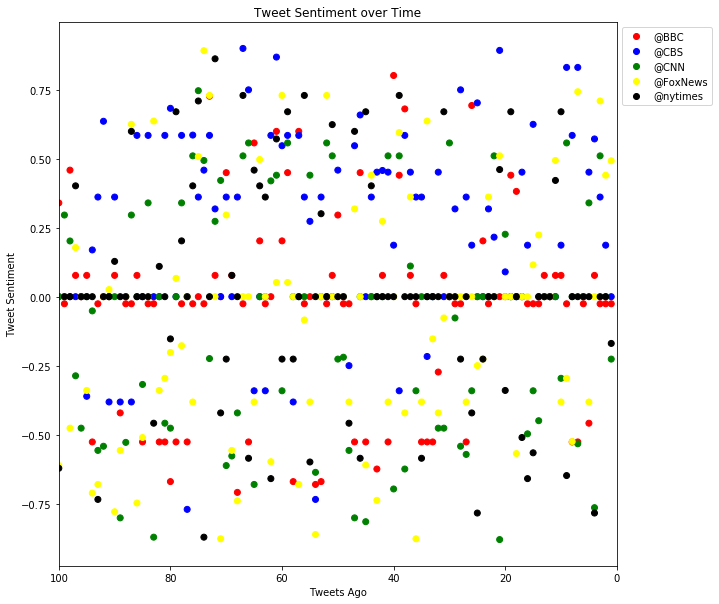

In [22]:
colors = {"@BBC":"red", "@CBS": "blue", "@CNN":"green", "@FoxNews":"yellow", "@nytimes":"black"}
plt.figure(figsize=(10,10))
plt.scatter(ind_results_df["Tweet Count"], ind_results_df["Compound Score"], c=ind_results_df["News Outlet"].apply(lambda x: colors[x]))
plt.ylabel("Tweet Sentiment")
plt.xlabel("Tweets Ago")
plt.title("Tweet Sentiment over Time")
plt.xlim(100,0)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
plt.legend(markers, colors.keys(), numpoints=1,bbox_to_anchor=(1, 1))

plt.savefig("IndTweet.png")